In [138]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

In [29]:
# read email data 
def read_data(filename):    
    # filename: string of the filename
    f = open(filename, "r")
    data = []
    for line in f:
        line = line.strip().split(',')
        line = list(map(float,line))
        data.append(line)
    return pd.DataFrame(data)

# read names 
def read_names(filename):
    f = open(filename,'r')
    names = []
    start_read = False
    for line in f:
        line = line.strip()
        if line and start_read:
            names.append(line.split(':')[0])
        if line.startswith('1, 0'):
            start_read = True
    names.append('spam')
    return names

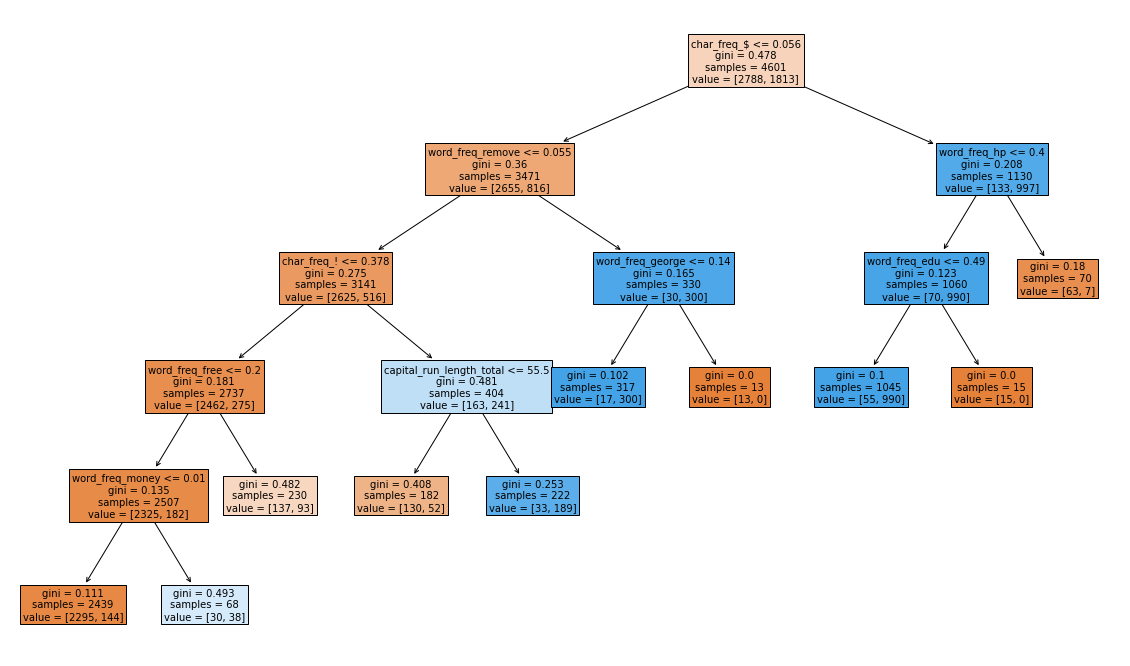

The test error of Rondom Forest Classifer:  0.06080347448425627
The test error of Decision Tree Classifer:  0.09880564603691644


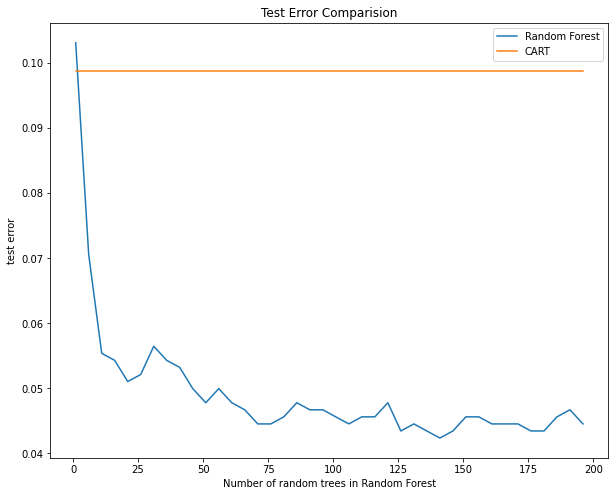

In [137]:
# read data
filename = 'spambase/spambase.data'
df = read_data(filename)
df.columns = read_names('spambase/spambase.names')

X = df.drop('spam', axis=1)
y = df['spam']

# decision tree classifier
clf_tree = tree.DecisionTreeClassifier(max_leaf_nodes = 10)
clf.fit(X, y)
plt.figure(figsize = (20,12))
tree.plot_tree(clf_tree,filled = True,fontsize=10,feature_names = df.columns[:-1])
plt.savefig('../Latex/images/tree.jpg')
plt.show()

# data partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# random forest classifier
clf_forest = RandomForestClassifier(random_state=0)
clf_forest.fit(X_train,y_train)
accuracy = clf_forest.score(X_test,y_test)
print('The test error of Rondom Forest Classifer: ', 1 -  accuracy)

# decision tree classifier
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train,y_train)
tree_accuracy = clf_tree.score(X_test,y_test)
print('The test error of Decision Tree Classifer: ', 1 -  tree_accuracy)


test_errors = []
for num_trees in range(1,200,5):
    model = RandomForestClassifier(n_estimators = num_trees, random_state=0)
    model.fit(X_train, y_train)
    score = model.score(X_test,y_test)
    test_errors.append([num_trees, 1 - score])
test_errors = np.array(test_errors)

tree_test_error = [1 - tree_accuracy] * len(test_errors)


fig, ax = plt.subplots(figsize = (10,8))
ax.plot(test_errors[:,0], test_errors[:,1], label = 'Random Forest')
ax.plot(test_errors[:,0], tree_test_error, label = 'CART')
plt.legend()
plt.title('Test Error Comparision')
plt.xlabel('Number of random trees in Random Forest')
plt.ylabel('test error')
# plt.show()
plt.savefig('../Latex/images/test_error.jpg')


## One-class SVM
# extract nonspam emails from the training data
X_train_nonspam = X_train[y_train == 0]

# train a one-class SVM using RBF kernel
clf = OneClassSVM(kernel = 'rbf', gamma = .03).fit(X_train_nonspam)
y_test_pred = clf.predict(X_test)

# inliers are nonspam emails
y_test_pred[y_test_pred == 1] = 0
# outliers are spam emails
y_test_pred[y_test_pred == -1] = 1

one_class_svm_test_error = sum(y_test_pred != y_test)/len(y_test)
print('The test error of One-class SVM: ',one_class_svm_test_error)

In [154]:
# find M
m = X_train.shape[0]

P = np.array(X_train) @ np.array(X_train).T
pairwise_distances = []
for i in range(m):
    for j in range(i+1,m):
        pairwise_distances.append(P[i,i] - 2 * P[i,j] + P[j,j])
M = np.median(np.array(pairwise_distances))

In [170]:
def ocsvm(X,gamma):
    clf = OneClassSVM(kernel = 'rbf', gamma = gamma ).fit(X)
    y_test_pred = clf.predict(X_test)
    # inliers are nonspam emails
    y_test_pred[y_test_pred == 1] = 0
    # outliers are spam emails
    y_test_pred[y_test_pred == -1] = 1

    one_class_svm_test_error = sum(y_test_pred != y_test)/len(y_test)
    return one_class_svm_test_error

In [176]:
gammas = np.arange(0.01,.5, 0.01)
opt_gamma = .1
opt_error = .4
for gamma in gammas:
    error = ocsvm(X_train_nonspam, gamma)
    if error < opt_error:
        opt_error = error
        opt_gamma = gamma
print('The optimal gamma is', opt_gamma)
print('The optimal error is', opt_error)

The optimal gamma is 0.03
The optimal error is 0.3561346362649294


In [182]:
ocsvm(X_train_nonspam, 1/M)

0.4245385450597177